## Анализ Рисков с помощью VaR

In [51]:
import pandas as pd
import pymongo
import datetime
import numpy as np
from statsmodels.stats.weightstats import zconfint
import matplotlib.pyplot as plt 
%matplotlib inline

from bson.son import SON
from pymongo import MongoClient

У нас слишком много данных, чтобы работать с ними в лоб, поэтому я воспользовался базой данных MongoDB, чтобы ускорить процесс работы с данными торговых операций. В дальнейшем, я действительно убедился, что MongoDB действительно использует гораздо меньше оперативной памяти, чем если бы я все считывал из исходных файлов.

## Импорт данных

Функция ниже дает доступ к MongoDB и базе данных, используя python. Работает похожим образом с jupyter notebook: MongoDB тоже запускается на виртуальном сервере через loopback.

In [267]:
def get_db_object():
    connection = pymongo.MongoClient('localhost', 27017)
    database = connection.MICEX
    return database

### Импорт по тикеру по всем данным

In [3]:
def import_data(seccode):
    micex_db = get_db_object()
    query = {
        "seccode": seccode 
            }
    projection = {
        "_id": 0,
        "volume": 0,
        "seccode": 0
    }
    data = pd.DataFrame(list(micex_db.trade_logs.find(query, projection)))
#    data.set_index('datetime', inplace=True)
    return data

### Импорт по тикеру за период

In [4]:
def import_data_by_date(seccode, start, end):
    micex_db = get_db_object()
    query = {
        "seccode": seccode, 
        "$and": 
        [ 
            { "datetime": { "$gt": start } }, 
            { "datetime": { "$lt": end } } 
        ]
    }
    projection = {
        "_id": 0,
        "volume": 0,
        "seccode": 0
    }
    data = pd.DataFrame(list(micex_db.trade_logs.find(query, projection)))
#    data.set_index('datetime', inplace=True)
    return data    

## Доступные тикеры в базе данных

In [182]:
def get_all_seccodes():    
    db = get_db_object()
    seccodes = db.trade_logs.distinct("seccode")
    return seccodes

In [183]:
seccodes = get_all_seccodes()

In [192]:
len(seccodes)

516

In [191]:
print(seccodes)

['ABRD', 'AESL', 'AFKS', 'AFLT', 'AGRO', 'AKRN', 'ALBK', 'ALNU', 'ALRS', 'AMEZ', 'APTK', 'AQUA', 'ARMD', 'ARSA', 'ASSB', 'AVAN', 'AVAZ', 'AVAZP', 'BANE', 'BANEP', 'BGDE', 'BISV', 'BISVP', 'BLNG', 'BRZL', 'BSPB', 'CBOM', 'CHEP', 'CHGZ', 'CHKZ', 'CHMF', 'CHMK', 'CHZN', 'CLSB', 'CLSBP', 'CNTL', 'CNTLP', 'DASB', 'DGBZ', 'DGBZP', 'DIOD', 'DIXY', 'DVEC', 'DZRD', 'DZRDP', 'ELTZ', 'ENRU', 'EONR', 'EPLN', 'FEES', 'FESH', 'FXAU', 'FXCN', 'FXDE', 'FXGD', 'FXIT', 'FXJP', 'FXMM', 'FXRB', 'FXRU', 'FXUK', 'FXUS', 'GAZA', 'GAZAP', 'GAZP', 'GCHE', 'GMKN', 'GRAZ', 'GRNT', 'GTLC', 'GTPR', 'GUMM', 'HALS', 'HIMCP', 'HYDR', 'IDVP', 'IGST', 'IGSTP', 'IRAO', 'IRGZ', 'IRKT', 'ISKJ', 'JNOS', 'JNOSP', 'KAZT', 'KAZTP', 'KBSB', 'KBTK', 'KCHE', 'KCHEP', 'KGKC', 'KGKCP', 'KLSB', 'KMAZ', 'KMEZ', 'KOGK', 'KRKN', 'KRKNP', 'KRKOP', 'KROT', 'KROTP', 'KRSB', 'KRSBP', 'KRSG', 'KTSB', 'KTSBP', 'KUBE', 'KUZB', 'KZOS', 'KZOSP', 'LIFE', 'LKOH', 'LNTA', 'LNZL', 'LNZLP', 'LPSB', 'LSNG', 'LSNGP', 'LSRG', 'LVHK', 'MAGE', 'MAGEP', 

## Выведем начальную и конечную дату по всему датасету

In [310]:
def start_date():
    micex_db = get_db_object()
    
    query = {}
    sort = [ (u"datetime", 1) ]
    
    cursor = micex_db.trade_logs.find(query, sort = sort, limit = 1)
    
    start_date = list(cursor)[0]['datetime']
    
    return start_date

In [308]:
def end_date():
    micex_db = get_db_object()
    
    query = {}
    sort = [ (u"datetime", -1) ]
    
    cursor = micex_db.trade_logs.find(query, sort = sort, limit = 1)
    
    end_date = list(cursor)[0]['datetime']
    
    return end_date

In [311]:
print(start_date())

2015-03-02 10:00:00


In [309]:
print(end_date())

2016-02-29 18:43:42


# Начиная отсюда до отметки "VaR, который считается по цене на конец нужного промежутка" код неактуален
Я решил пока что оставить старые варианты подсчета, чтобы была возможность сравнить новые и старые алгоритмы.

## VaR для n интервалов

#### Код ниже использует цену НЕ на конец дня/недели/часа и т.д., поэтому не используется.

In [3]:
#опция для импорта за нужный промежуток
start = datetime.datetime(year = 2015, month = 9, day = 9)
end = datetime.datetime(year = 2015, month = 10, day = 9)

Брать цены на конец дня. Считать доходность по ним.

In [24]:
def VaR_n_intervals(data, freq):
       
    intervals = np.linspace(0, data.shape[0] - 1, num=freq)
    intervals = [int(i) for i in intervals]
    dates = [(data.datetime.iloc[interval] - data.datetime.iloc[0]).days for interval in intervals]
    VaRs = []
    prices = [data.price.iloc[i] for i in intervals]
    data.price = data.price/data.price.iloc[0]
    

    for i in intervals:
        if i == 0:
            next
        else:
            VaRs.append(zconfint(data[0:i].price))
#            print(dates[j], zconfint(data[0:i].price))

    VaR_lower = [((1 - VaR[0]) * prices[0]) for VaR in VaRs]
    return VaR_lower, dates

In [14]:
def plot_VaR(seccode, VaR, dates):
    plt.plot(dates[1:], VaR, c = 'b')
    plt.xlabel('Days')
    plt.ylabel('Loss per unit of stock, RUB')
    plt.title(seccode)
    plt.show()

In [25]:
def import_and_plot_n_intervals(seccode, frequency):
    start_time = datetime.datetime.now()
    data = import_data(seccode)
    VaRs, dates, prices = VaR(data, 20)
    finish_time = datetime.datetime.now()
    print("Time spent:", finish_time - start_time)
    plot_VaR(seccode, VaRs, dates)
    

In [43]:
def plot_n_intervals(data, frequency):
    start_time = datetime.datetime.now()
    VaRs, dates, prices = VaR_n_intervals(data, 20)
    finish_time = datetime.datetime.now()
    print("Time spent:", finish_time - start_time)
    plot_VaR(seccode, VaRs, dates)

In [ ]:
plot_n_intervals(data = data, frequency = 36)

In [ ]:
import_and_plot_n_intervals(seccode = 'LKOH', frequency = 36)

In [ ]:
import_and_plot_n_intervals(seccode = 'SBER', frequency = 36)

Time spent:  0:03:05.281101


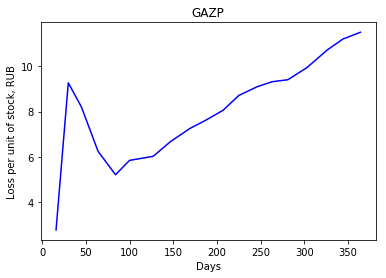

In [29]:
import_and_plot_n_intervals(seccode = 'GAZP', frequency = 36)

## VaR для timedelta

#### Медленно работает и считает нижнюю границу доверительного интервала по всем данным за промежуток, а не на по цене закрытия.

In [39]:
def VaR_timedelta(data, time_deltas, time_delta_names):
    for (delta, delta_name) in zip(time_deltas, time_delta_names):
        
        start_date = data.datetime.iloc[0]
        end_date = data.datetime.iloc[-1]
        
        VaRs = []
        dates = []
        
        while start_date <= end_date:
            interval_data = data[(data.datetime >= start_date) & (data.datetime < start_date + delta)]
            if len(interval_data) == 0:
                start_date += delta
                continue
            if len(interval_data) == 1:
                VaRs.append(0)
            else:    
                returns = interval_data.price/interval_data.price.iloc[0] - 1
                VaRs.append(zconfint(returns)[0])
            start_date += delta
            dates.append(start_date)
        plt.plot(dates, VaRs, c = 'b')
        plt.xlabel('Time periods')
        plt.ylabel('Maximum loss per unit of stock')
        plt.title(delta_name)
        plt.show()

In [14]:
time_deltas = [
                datetime.timedelta(seconds=1, minutes=0, hours=0, days=0, weeks=0),
                datetime.timedelta(seconds=0, minutes=1, hours=0, days=0, weeks=0),
                datetime.timedelta(seconds=0, minutes=0, hours=1, days=0, weeks=0),
                datetime.timedelta(seconds=0, minutes=0, hours=0, days=1, weeks=0),
                datetime.timedelta(seconds=0, minutes=0, hours=0, days=0, weeks=1)
                ]

In [15]:
time_delta_names = ['secs', 'mins', 'hours', 'days', 'weeks']

In [19]:
#для запуска lprun
%load_ext line_profiler

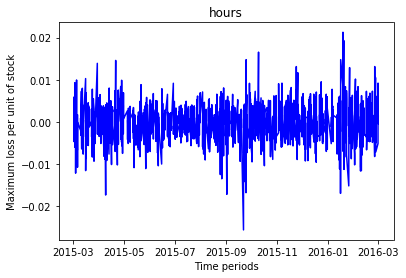

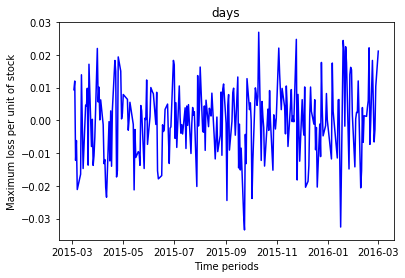

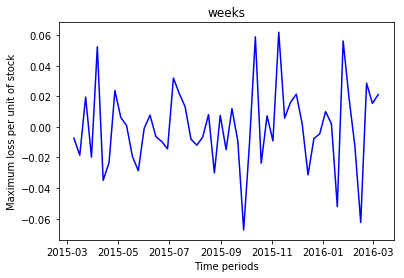

Timer unit: 1e-06 s

Total time: 214.951 s
File: <ipython-input-39-63946bd31bcd>
Function: VaR_timedelta at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def VaR_timedelta(data, time_deltas, time_delta_names):
     2         4         13.0      3.2      0.0      for (delta, delta_name) in zip(time_deltas, time_delta_names):
     3                                                   
     4         3        457.0    152.3      0.0          start_date = data.datetime.iloc[0]
     5         3        213.0     71.0      0.0          end_date = data.datetime.iloc[-1]
     6                                                   
     7         3         31.0     10.3      0.0          VaRs = []
     8         3         27.0      9.0      0.0          dates = []
     9                                                   
    10      9166      12008.0      1.3      0.0          while start_date <= end_date:
    11      9163  211

In [41]:
%lprun -f VaR_timedelta VaR_timedelta(data = data, time_deltas = time_deltas[2:], time_delta_names = time_delta_names[2:])

In [27]:
%%time
data = import_data(seccode = 'LKOH')

CPU times: user 20.7 s, sys: 8.52 s, total: 29.2 s
Wall time: 2min 7s


In [35]:
data.head()

,datetime,price
0,2015-03-02 10:00:00,2989.0
1,2015-03-02 10:00:00,2989.0
2,2015-03-02 10:00:00,2989.0
3,2015-03-02 10:00:00,2990.0
4,2015-03-02 10:00:00,2994.0


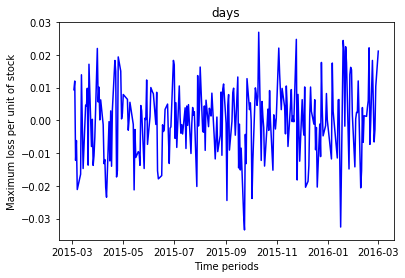

CPU times: user 13.3 s, sys: 2.89 s, total: 16.2 s
Wall time: 8.43 s


In [37]:
%%time

delta = time_deltas[-2]
delta_name = time_delta_names[-2]

start_date = data.datetime.iloc[0]
end_date = data.datetime.iloc[-1]

VaRs = []
dates = []

while start_date <= end_date:
    interval_data = data[(data.datetime >= start_date) & (data.datetime < start_date + delta)]
    if len(interval_data) == 0:
        start_date += delta
        continue
#        print("continue")
    if len(interval_data) == 1:
        VaRs.append(0)
#        print(0)
    else:    
        returns = interval_data.price/interval_data.price.iloc[0] - 1
        VaRs.append(zconfint(returns)[0])
#        print(zconfint(returns)[0])
    start_date += delta
    dates.append(start_date)
plt.plot(dates, VaRs, c = 'b')
plt.xlabel('Time periods')
plt.ylabel('Maximum loss per unit of stock')
plt.title(delta_name)
plt.show()

# Та самая отметка, после которой можно смотреть код и небольшой вывод

## VaR, который считается по цене на конец нужного промежутка.

Перед подсчетом VaR отправляется запрос в базу данных. Ниже варианты запроса в MongoDB для получения цен на конец недели, дня, часа, минуты, секунды. 

### Неделя

In [247]:
def import_week_closing_prices(seccode):    
    database = get_db_object()
    collection = database["trade_logs"]
    
    pipeline = [
        {
            u"$match": {
                u"seccode": seccode
            }
        }, 
# опция для лимита сделок        
#        {
#            u"$limit": 100000.0
#        }, 
        {
            u"$sort": SON([ (u"datetime", 1) ])
        }, 
        {
            u"$project": {
                u"date": {
                    u"$dateToString": {
                        u"format": u"%Y-%U",
                        u"date": u"$datetime"
                    }
                },
                u"price": u"$price",
                u"seccode": u"$seccode"
            }
        }, 
        {
            u"$group": {
                u"_id": u"$date",
                u"price": {
                    u"$last": u"$price"
                }
            }
        }
    ]
    
    cursor = collection.aggregate(
        pipeline, 
        allowDiskUse = False
    )

    df =  pd.DataFrame(list(cursor))
    df._id = pd.to_datetime(df._id + '-1', format='%Y-%W-%w') #дает понедельник на нужной неделе, используется только для отображения
    df = df.sort_values(by = '_id')
    df = df.reset_index(drop=True)
    
    return df

### День

In [185]:
def import_day_closing_prices(seccode):    
    database = get_db_object()
    collection = database["trade_logs"]
    
    pipeline = [
        {
            u"$match": {
                u"seccode": seccode
            }
        }, 
#        {
#            u"$limit": 100000.0
#        }, 
        {
            u"$sort": SON([ (u"datetime", 1) ])
        }, 
        {
            u"$project": {
                u"date": {
                    u"$dateToString": {
                        u"format": u"%Y-%m-%d",
                        u"date": u"$datetime"
                    }
                },
                u"price": u"$price",
                u"seccode": u"$seccode"
            }
        }, 
        {
            u"$group": {
                u"_id": u"$date",
                u"price": {
                    u"$last": u"$price"
                }
            }
        }
    ]
    
    cursor = collection.aggregate(
        pipeline, 
        allowDiskUse = False
    )

    df =  pd.DataFrame(list(cursor))
    df['_id'] =  pd.to_datetime(df['_id'], format='%Y/%m/%d')
    df = df.sort_values(by = '_id')
    df = df.reset_index(drop=True)
    
    return df

### Час

In [249]:
def import_hour_closing_prices(seccode):    
    database = get_db_object()
    collection = database["trade_logs"]
    
    pipeline = [
        {
            u"$match": {
                u"seccode": seccode
            }
        }, 
#        {
#            u"$limit": 100000.0
#        }, 
        {
            u"$sort": SON([ (u"datetime", 1) ])
        }, 
        {
            u"$project": {
                u"date": {
                    u"$dateToString": {
                        u"format": u"%Y-%m-%d-%H",
                        u"date": u"$datetime"
                    }
                },
                u"price": u"$price",
                u"seccode": u"$seccode"
            }
        }, 
        {
            u"$group": {
                u"_id": u"$date",
                u"price": {
                    u"$last": u"$price"
                }
            }
        }
    ]
    
    cursor = collection.aggregate(
        pipeline, 
        allowDiskUse = False
    )

    df =  pd.DataFrame(list(cursor))
    df['_id'] =  pd.to_datetime(df['_id'], format='%Y-%m-%d-%H')
    df = df.sort_values(by = '_id')
    df = df.reset_index(drop=True)
    
    return df

### Минута

In [261]:
def import_minute_closing_prices(seccode):    
    database = get_db_object()
    collection = database["trade_logs"]
    
    pipeline = [
        {
            u"$match": {
                u"seccode": seccode
            }
        }, 
#        {
#            u"$limit": 100000.0
#        }, 
        {
            u"$sort": SON([ (u"datetime", 1) ])
        }, 
        {
            u"$project": {
                u"date": {
                    u"$dateToString": {
                        u"format": u"%Y-%m-%d-%H-%M",
                        u"date": u"$datetime"
                    }
                },
                u"price": u"$price",
                u"seccode": u"$seccode"
            }
        }, 
        {
            u"$group": {
                u"_id": u"$date",
                u"price": {
                    u"$last": u"$price"
                }
            }
        }
    ]
    
    cursor = collection.aggregate(
        pipeline, 
        allowDiskUse = False
    )

    df =  pd.DataFrame(list(cursor))
    df['_id'] =  pd.to_datetime(df['_id'], format='%Y-%m-%d-%H-%M')
    df = df.sort_values(by = '_id')
    df = df.reset_index(drop=True)
    
    return df

### Секунда

In [263]:
def import_seconds_closing_prices(seccode):    
    database = get_db_object()
    collection = database["trade_logs"]
    
    pipeline = [
        {
            u"$match": {
                u"seccode": seccode
            }
        }, 
#        {
#            u"$limit": 100000.0
#        }, 
        {
            u"$sort": SON([ (u"datetime", 1) ])
        }, 
        {
            u"$project": {
                u"date": {
                    u"$dateToString": {
                        u"format": u"%Y-%m-%d-%H-%M-%S",
                        u"date": u"$datetime"
                    }
                },
                u"price": u"$price",
                u"seccode": u"$seccode"
            }
        }, 
        {
            u"$group": {
                u"_id": u"$date",
                u"price": {
                    u"$last": u"$price"
                }
            }
        }
    ]
    
    cursor = collection.aggregate(
        pipeline, 
        allowDiskUse = False
    )

    df =  pd.DataFrame(list(cursor))
    df['_id'] =  pd.to_datetime(df['_id'], format='%Y-%m-%d-%H-%M-%S')
    df = df.sort_values(by = '_id')
    df = df.reset_index(drop=True)
    
    return df

# Функция, считающая VaR
Функция получает на вход цены закрытия с соответствующими датами, а также частоту и тикер для зарисовки графика.
Сначала она считает доходность, далее считает нижнюю границу доверительного интервала через нормальное распределение.
На первой итерации нижняя граница оценивается по первым двум доходностям. На каждой следующей добавляется еще одна доходность, соответствующая цене закрытия следующего временного промежутка.

In [264]:
def VaR_closing_price(data, frequency, seccode):
    
    returns = np.array(data[1:].price) / np.array(data[:-1].price) - 1
    dates = data._id[2:]
    
    VaRs = []

    for i in range(2, len(returns) + 1):
        VaRs.append(zconfint(returns[:i])[0])
        
    plt.plot(dates, VaRs)
    plt.xlabel('Date')
    plt.ylabel('Maximum loss per unit of stock')
    plt.title('VaR on ' + frequency + ' close price, ' + seccode)
    plt.show()

## Примеры подсчета

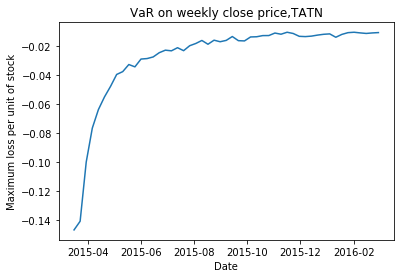

CPU times: user 295 ms, sys: 159 ms, total: 454 ms
Wall time: 2min 5s


In [257]:
%%time
VaR_closing_price(data = import_week_closing_prices(seccode = 'TATN'), frequency = 'weekly', seccode = 'TATN')

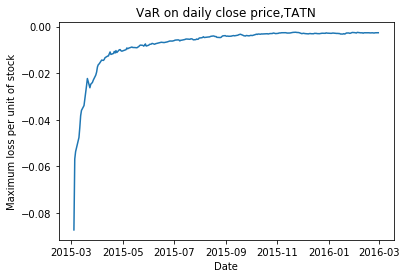

CPU times: user 271 ms, sys: 90.5 ms, total: 361 ms
Wall time: 1min 26s


In [258]:
%%time
VaR_closing_price(data = import_day_closing_prices(seccode = 'TATN'), frequency = 'daily', seccode = 'TATN')

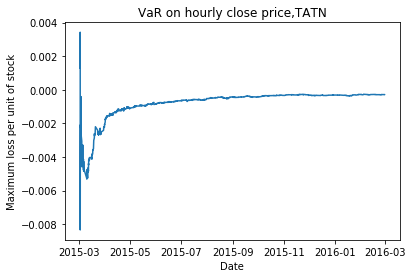

CPU times: user 571 ms, sys: 63.4 ms, total: 635 ms
Wall time: 1min 2s


In [259]:
%%time
VaR_closing_price(data = import_hour_closing_prices(seccode = 'TATN'), frequency = 'hourly', seccode = 'TATN')

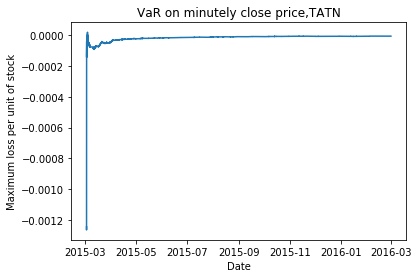

CPU times: user 32.4 s, sys: 1.63 s, total: 34.1 s
Wall time: 2min 16s


In [262]:
%%time
VaR_closing_price(data = import_minute_closing_prices(seccode = 'TATN'), frequency = 'minutely', seccode = 'TATN')

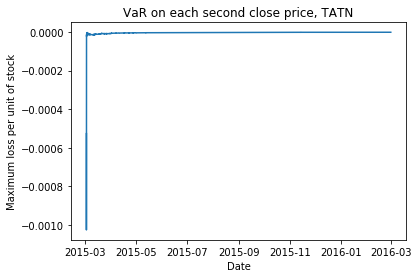

CPU times: user 12min 17s, sys: 3min 41s, total: 15min 59s
Wall time: 18min 21s


In [265]:
%%time
VaR_closing_price(data = import_seconds_closing_prices(seccode = 'TATN'), frequency = 'each second', seccode = 'TATN')

In [266]:
%%bash
say finished

## Как это работает?
Базе данных отправляется запрос, который группирует данные по временным промежуткам, после чего из каждой группы база данных отдает самое последнее значение как цену закрытия. Далее все это это подается функции, считающей VaR.

## Небольшой вывод
- __Работает быстрее__ <br> 
Для подсчета более высокочастного VaR этот алгоритм работает быстрее, чем если сначала ипортировать все данные по тикеру из базы данных в датафрейм, а потом выбирать оттуда цены закрытия. Алгоритм не требователен к частоте и многопоточности процессора, но его можно ускорить на компьютере с более быстрой памятью.
- __Посекундно считается долго__ <br>
В случае с Татнефтью алгоритм работал 18 минут 21 секунду. По сравнению с подсчетом для других интервалов, которые в среднем занимают около  полуторы минуты, это существенно дольше. Интересно то, что база данных выполняет запрос для посекундных цен закрытия за минуты 2-3, все остальное время оценивается VaR. Посекундных данных действительно много: 8.5 часов ежедневно в течении 250 дней. Итого, мы получаем 8 100 000 цен закрытия, при условии, что сделка происходила каждую секунду. Чаще всего посекундный датасет цен закрытия будет по размерности близок в 8 100 000.
- __Похоже на закон больших чисел__ <br>
Дейсвительно, в каждом следующем случае мы берем все более высокую частоту данных, и доверительный интервал сужается быстрее и быстрее. В случае с часовы подсчетом, VaR в начале графика оказался положительным, что, скорее всего, произошло из-за небольшого размера выборки на самых первых итерациях. Далее, как и должно быть, график уже лежит ниже нуля.
